In [ ]:
# Change this if you are running it in Ananaconda. Everything else should be the same
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pwd
!ls

/content
drive  sample_data


In [35]:
import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [36]:
# Use this if you want to just upload from your computer
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(r"DataDigiEdu.csv", encoding='utf-8', delimiter=';')

Saving DataDigiEdu.csv to DataDigiEdu (2).csv


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/DataDigiEdu.csv'
df = pd.read_csv(file_path, encoding='utf-8', delimiter=';')

In [37]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 928 entries, 0 to 927
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  928 non-null    int64 
 1   Selbstbeschreibung  909 non-null    object
dtypes: int64(1), object(1)
memory usage: 14.6+ KB


,ID
count,928.000000
mean,509.207974
std,275.189500
min,1.000000
25%,271.750000
50%,507.500000
75%,747.250000
max,986.000000


Preprocessing steps before tokoneization using BERT.


1.   Stemming
2.   Remove special characters, extra spaces and numbers
3. convert to lower case
4. remove stop words

Remove rows with null values




In [38]:
# Initialize Snowball Stemmer for stemming
stemmer = SnowballStemmer('german')

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define function for preprocessing and tokenization
def preprocess_and_tokenize(text):
    # Remove special characters, numbers, extra spaces
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    # Convert text to lowercase
    text = text.lower()

    # Remove stop words
    stop_words = set(stopwords.words('german'))
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]

    # Perform stemming
    stemmed_words = [stemmer.stem(word) for word in words]

    # Tokenize using BERT tokenizer
    tokens = tokenizer(' '.join(stemmed_words), return_tensors='pt', truncation=True, padding=True)['input_ids']

    # Count number of words
    num_words = len(words)

    # Reconstruct processed text
    processed_text = ' '.join(stemmed_words)

    return tokens, num_words, processed_text

# Create a new DataFrame without null values
df = df.dropna(subset=['Selbstbeschreibung']).copy()

# Apply preprocessing and tokenization to each description
df['Tokens'], df['Num_Words'], df['Processed_Text'] = zip(*df['Selbstbeschreibung'].apply(preprocess_and_tokenize))

# Calculate number of words for each row in the Selbstbeschreibung column
df['Num_Words_Selbstbeschreibung'] = df['Selbstbeschreibung'].apply(lambda x: len(x.split()))

# Now 'Num_Words_Selbstbeschreibung' column contains the number of words in each row of the Selbstbeschreibung column
# Now 'Tokens' column contains tokenized sequences suitable for BERT input
# 'Num_Words' column contains the number of words in each description after preprocessing
# 'Processed_Text' column contains the processed text


In [39]:
df.head()

,ID,Selbstbeschreibung,Tokens,Num_Words,Processed_Text,Num_Words_Selbstbeschreibung
0,1,Unternehmen sind von der digitalen Transformat...,"[[tensor(101), tensor(4895), tensor(16451), te...",30,unternehm digital transformation unmittelbar b...,48
1,6,Die Digitalisierung eröffnet ungeahnte Möglich...,"[[tensor(101), tensor(3617), tensor(17417), te...",30,digitalisier erffnet ungeahnt mglichkeit fr in...,43
2,32,Die erfolgreiche Nutzung digitaler Medien zur ...,"[[tensor(101), tensor(9413), tensor(14876), te...",54,erfolgreich nutzung digital medi erreich marke...,95
3,33,In den dynamischen Märkten der Gegenwart und Z...,"[[tensor(101), tensor(1040), tensor(18279), te...",79,dynam mrkten gegenwart zukunft mssen market st...,147
4,34,"Während der stationäre, ""klassische"" Detailhan...","[[tensor(101), tensor(1059), tensor(28362), te...",38,whrend stationr klassisch detailhandel stagnie...,61


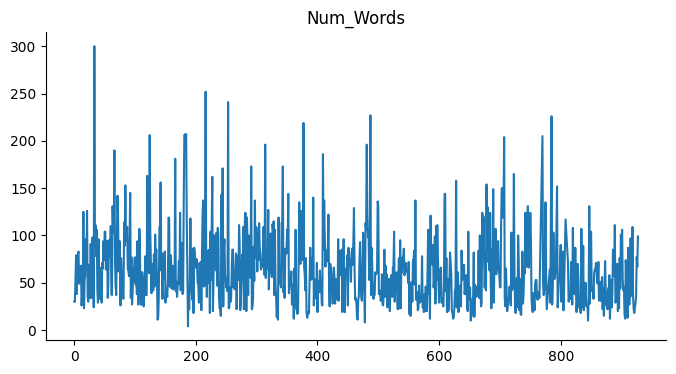

In [ ]:
# @title Num_Words - Numer of words in description

from matplotlib import pyplot as plt
df['Num_Words'].plot(kind='line', figsize=(8, 4), title='Num_Words')
plt.gca().spines[['top', 'right']].set_visible(False)

Use BERT to tokenize the words in the description. Then use Cosine Similarity to calculate uniqueness of each description.

https://en.wikipedia.org/wiki/Cosine_similarity

1. Get BERT embeddings from the tokens generated in the last step
2. Generate a cosine similarity matrix from the bert embeddings and use that to calculate uniqueness score.



In [44]:
from transformers import BertModel

bert_model = BertModel.from_pretrained('bert-base-uncased')

# Set the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Put the model on the selected device
bert_model.to(device)

# Function to get BERT embeddings
def get_bert_embeddings(tokens):
    # Move tokens to the selected device
    tokens = tokens.to(device)

    # Get BERT embeddings
    with torch.no_grad():
        outputs = bert_model(tokens)
        # Extract the last layer's hidden states (CLS token) as embeddings
        embeddings = outputs.last_hidden_state[:, 0, :]

    # Move embeddings back to CPU if necessary
    embeddings = embeddings.cpu().numpy()

    return embeddings

# Apply the function to get BERT embeddings for each row
df['BERT_Embeddings'] = df['Tokens'].apply(get_bert_embeddings)


In [50]:
df.head()

,ID,Selbstbeschreibung,Tokens,Num_Words,Processed_Text,Num_Words_Selbstbeschreibung,BERT_Embeddings
0,1,Unternehmen sind von der digitalen Transformat...,"[[tensor(101), tensor(4895), tensor(16451), te...",30,unternehm digital transformation unmittelbar b...,48,"[[-0.18138511, 0.32646254, 0.44138795, -0.2462..."
1,6,Die Digitalisierung eröffnet ungeahnte Möglich...,"[[tensor(101), tensor(3617), tensor(17417), te...",30,digitalisier erffnet ungeahnt mglichkeit fr in...,43,"[[-0.6243696, 0.059732415, 0.12582172, -0.3767..."
2,32,Die erfolgreiche Nutzung digitaler Medien zur ...,"[[tensor(101), tensor(9413), tensor(14876), te...",54,erfolgreich nutzung digital medi erreich marke...,95,"[[-0.33330163, 0.3867966, 0.34473076, -0.13911..."
3,33,In den dynamischen Märkten der Gegenwart und Z...,"[[tensor(101), tensor(1040), tensor(18279), te...",79,dynam mrkten gegenwart zukunft mssen market st...,147,"[[-0.24944122, 0.2211311, 0.3056313, -0.143414..."
4,34,"Während der stationäre, ""klassische"" Detailhan...","[[tensor(101), tensor(1059), tensor(28362), te...",38,whrend stationr klassisch detailhandel stagnie...,61,"[[-0.33990398, 0.374503, 0.24552338, -0.281801..."


In [53]:
from sklearn.metrics.pairwise import cosine_similarity

# Flatten the BERT embeddings
flattened_embeddings = df['BERT_Embeddings'].apply(lambda x: x.flatten()).tolist()

# Calculate cosine similarity between all pairs of embeddings
cos_sim_matrix = cosine_similarity(flattened_embeddings)

# Step 6: Calculate Uniqueness Score
uniqueness_scores = 1 - cos_sim_matrix

# Step 7: Normalize Uniqueness Scores (Optional)
scaler = MinMaxScaler()
normalized_scores = scaler.fit_transform(uniqueness_scores)

# Add the uniqueness scores to the dataframe
df['Uniqueness_Score'] = normalized_scores.mean(axis=1)  # Taking the mean uniqueness score across all other programs
df['Uniqueness_Score'] = (df['Uniqueness_Score'] * 100).round(3)


In [54]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 909 entries, 0 to 927
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            909 non-null    int64  
 1   Selbstbeschreibung            909 non-null    object 
 2   Tokens                        909 non-null    object 
 3   Num_Words                     909 non-null    int64  
 4   Processed_Text                909 non-null    object 
 5   Num_Words_Selbstbeschreibung  909 non-null    int64  
 6   BERT_Embeddings               909 non-null    object 
 7   Uniqueness_Score              909 non-null    float32
dtypes: float32(1), int64(3), object(4)
memory usage: 92.7+ KB


,ID,Num_Words,Num_Words_Selbstbeschreibung,Uniqueness_Score
count,909.000000,909.000000,909.000000,909.000000
mean,502.941694,63.882288,108.787679,38.978596
std,274.130965,38.973735,67.032424,9.209843
min,1.000000,4.000000,8.000000,26.111000
25%,267.000000,35.000000,61.000000,32.678001
50%,497.000000,55.000000,95.000000,36.743000
75%,735.000000,83.000000,139.000000,43.236000
max,986.000000,300.000000,523.000000,89.068001


Descriptive Statistics for 'Uniqueness_Score' column:
count    909.000000
mean      38.978596
std        9.209843
min       26.111000
25%       32.678001
50%       36.743000
75%       43.236000
max       89.068001
Name: Uniqueness_Score, dtype: float64


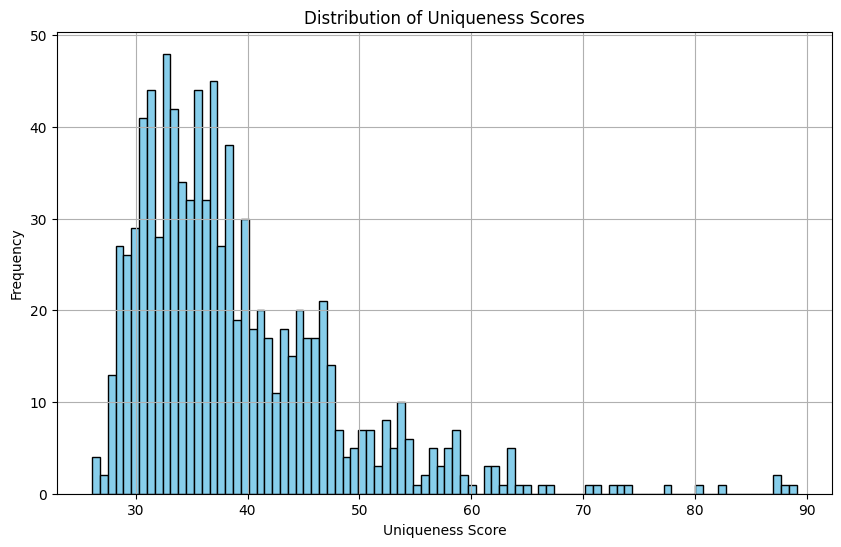

In [55]:
print("Descriptive Statistics for 'Uniqueness_Score' column:")
print(df['Uniqueness_Score'].describe())

# Histogram to visualize the distribution
plt.figure(figsize=(10, 6))
plt.hist(df['Uniqueness_Score'], bins=90, color='skyblue', edgecolor='black')
plt.title('Distribution of Uniqueness Scores')
plt.xlabel('Uniqueness Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


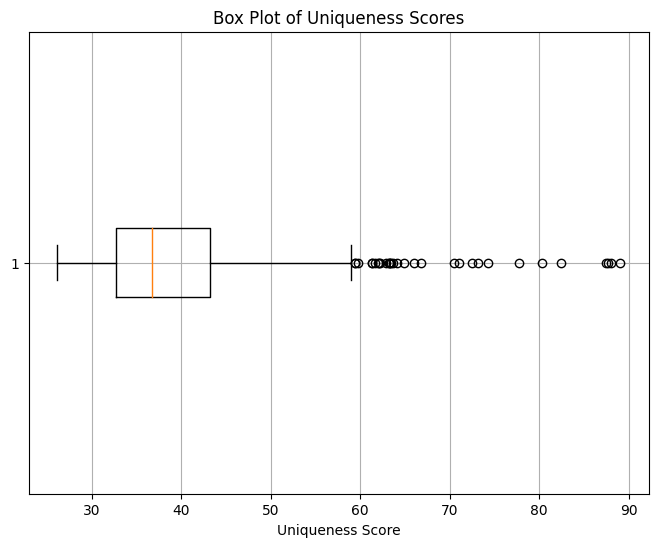

In [56]:

# Box plot to identify outliers
plt.figure(figsize=(8, 6))
plt.boxplot(df['Uniqueness_Score'], vert=False)
plt.title('Box Plot of Uniqueness Scores')
plt.xlabel('Uniqueness Score')
plt.grid(True)
plt.show()

Now I would like to see how well the Uniqueness score works. So for that I used Kmeans to cluster the descriptions. I also used the elbow method and few other metrics to tune the clustering method.Elbow method shows the optimum number of clusters is 14 or 30. Here I went with 14.  After that i check the uniqueness score of the items in each cluster.

A good way to determin if the uniqueness scores is to see if the scores of the items in a cluster are similar. If they are fairly similar then everything works fine. See the code and the visualizations.


In [57]:
from sklearn.cluster import KMeans

In [74]:
# Extract BERT embeddings as features for clustering
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit TF-IDF vectorizer on preprocessed text
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Processed_Text'])

# Initialize KMeans with the number of clusters
kmeans = KMeans(n_clusters=14, random_state=42)

# Fit KMeans clustering on the BERT embeddings
kmeans.fit(tfidf_matrix)

# Predict cluster labels
cluster_labels = kmeans.labels_


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


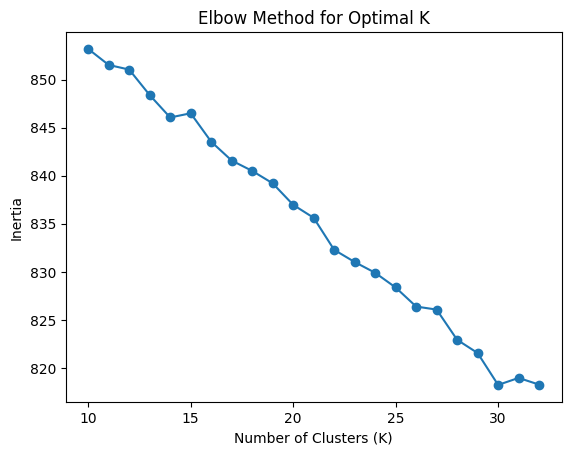

In [70]:

# Range of K values to test
k_values = range(10, 33)
inertia_values = []

# Fit KMeans for each value of K and calculate inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

These metrics show well K means performs

In [75]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Inertia
inertia = kmeans.inertia_

# Silhouette Score
silhouette_avg = silhouette_score(X, cluster_labels)

# Calinski-Harabasz Index
calinski_harabasz = calinski_harabasz_score(X, cluster_labels)

# Davies-Bouldin Index
davies_bouldin = davies_bouldin_score(X, cluster_labels)

print("Inertia:", inertia)
print("Silhouette Score:", silhouette_avg)
print("Calinski-Harabasz Index:", calinski_harabasz)
print("Davies-Bouldin Index:", davies_bouldin)


Inertia: 846.059737724365
Silhouette Score: -0.017200563
Calinski-Harabasz Index: 5.6891730368878735
Davies-Bouldin Index: 6.690722426663929


In [76]:
# Add cluster labels as a new column to the DataFrame
df['Cluster_Labels'] = cluster_labels

                count        min        max       mean
Cluster_Labels                                        
0                  44  27.274000  64.928001  40.430500
1                 164  26.111000  88.032997  37.136185
2                  28  28.260000  61.353001  38.774822
3                  16  30.051001  63.368999  39.277061
4                  73  28.176001  87.467003  40.645058
5                  64  27.683001  87.638000  38.008968
6                  64  26.410000  59.730000  37.336891
7                 119  26.186001  77.727997  38.797791
8                 119  28.771999  89.068001  39.657269
9                  32  31.112000  73.155998  44.194439
10                 58  27.372999  64.125999  38.440914
11                 51  28.250999  70.991997  40.515903
12                 27  27.663000  56.498001  37.690334
13                 50  28.295000  74.238998  39.900360


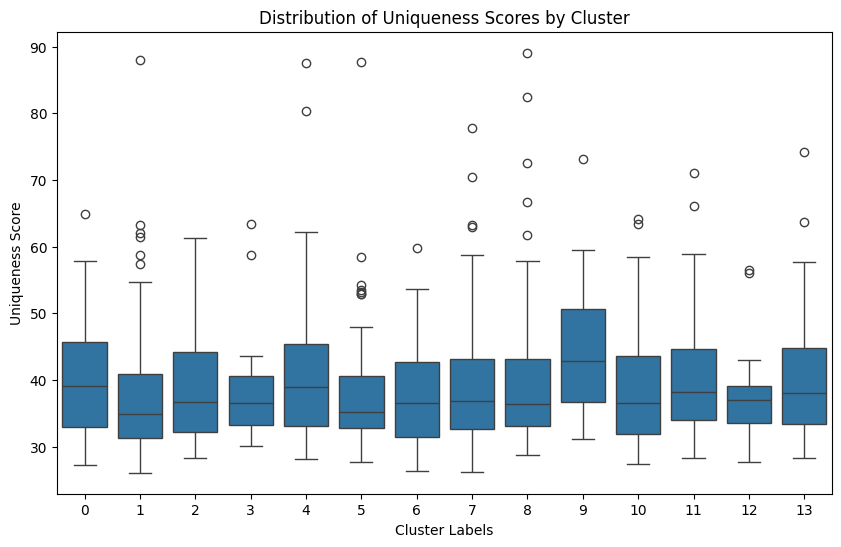

In [83]:
# Group the DataFrame by the 'Cluster_Labels' column
cluster_stats = df.groupby('Cluster_Labels')['Uniqueness_Score'].agg(['count', 'min', 'max', 'mean'])

# Print the number of items, min, max, and average uniqueness score for each cluster
print(cluster_stats)

# Create a box plot of uniqueness scores for each cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster_Labels', y='Uniqueness_Score', data=df)
plt.title('Distribution of Uniqueness Scores by Cluster')
plt.xlabel('Cluster Labels')
plt.ylabel('Uniqueness Score')
plt.show()


This code will print the number of items in each cluster, the number of unique values, and the count of unique values that differ by a maximum of ±2.


In [78]:
for cluster in df['Cluster_Labels'].unique():
    cluster_data = df[df['Cluster_Labels'] == cluster]['Uniqueness_Score']
    unique_values = sorted(cluster_data.unique())
    unique_diff_2 = sum(abs(unique_values[i] - unique_values[i-1]) <= 2 for i in range(1, len(unique_values)))
    print(f"Cluster {cluster}:")
    print(f"  Number of items: {len(cluster_data)}")
    print(f"  Number of unique values: {len(unique_values)}")
    print(f"  Number of unique values differing by ±2: {unique_diff_2}\n")


Cluster 9:
  Number of items: 32
  Number of unique values: 32
  Number of unique values differing by ±2: 25

Cluster 7:
  Number of items: 119
  Number of unique values: 119
  Number of unique values differing by ±2: 113

Cluster 1:
  Number of items: 164
  Number of unique values: 161
  Number of unique values differing by ±2: 156

Cluster 5:
  Number of items: 64
  Number of unique values: 63
  Number of unique values differing by ±2: 57

Cluster 4:
  Number of items: 73
  Number of unique values: 71
  Number of unique values differing by ±2: 64

Cluster 13:
  Number of items: 50
  Number of unique values: 49
  Number of unique values differing by ±2: 43

Cluster 3:
  Number of items: 16
  Number of unique values: 16
  Number of unique values differing by ±2: 11

Cluster 6:
  Number of items: 64
  Number of unique values: 62
  Number of unique values differing by ±2: 59

Cluster 8:
  Number of items: 119
  Number of unique values: 113
  Number of unique values differing by ±2: 106



In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 909 entries, 0 to 927
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            909 non-null    int64  
 1   Selbstbeschreibung            909 non-null    object 
 2   Tokens                        909 non-null    object 
 3   Num_Words                     909 non-null    int64  
 4   Processed_Text                909 non-null    object 
 5   Num_Words_Selbstbeschreibung  909 non-null    int64  
 6   BERT_Embeddings               909 non-null    object 
 7   Uniqueness_Score              909 non-null    float32
 8   Cluster_Labels                909 non-null    int32  
dtypes: float32(1), int32(1), int64(3), object(4)
memory usage: 96.2+ KB


In [80]:
df.to_csv('final_dataframe.csv', index=False)

In [81]:
df.to_csv('/content/drive/My Drive/final_dataframe.csv', index=False)